## K means Clustering
Unsupervised technique used in data exploration, market segmentation, image segmentation and compression, document topic clustering, etc.

k distinct non-overlapping clusters where each data point belongs to only one group.

### K-nearest neighbors
Supervised technique using that makes a prediction for point y_i based on an average/vote of the k nearest points. Can be used for either classification or regression

#### Question
What is the big-O complexity of k-means?

O(mnk)
k: number of clusters
n: number of data points
m: number of dimensions/features

#### Housekeeping

In [0]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.metrics import pairwise_distances_argmin
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score 

#### Some toy data

In [0]:
alldata = pd.read_csv('sample_data/california_housing_test.csv')
alldata.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0


In [0]:
data = alldata[['longitude','latitude','median_house_value']].copy().sample(500)
data.dropna(inplace=True)
# data['median_house_value'] = data['median_house_value'].apply(lambda x: x/1000)
data.head(5)

,longitude,latitude,median_house_value
1535,-117.92,33.73,205800.0
1110,-117.84,33.80,222100.0
588,-121.00,37.66,138100.0
2255,-122.48,37.51,318500.0
1821,-118.46,34.07,500001.0


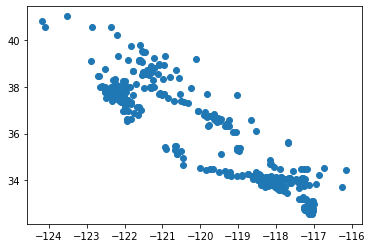

In [0]:
plt.scatter(data.longitude,data.latitude)
plt.show()

In [0]:
# fig = plt.figure()
# ax = Axes3D(fig)

# ax.scatter(data.longitude,data.latitude,data.median_house_value)
# plt.show()

In [0]:
fig = px.scatter_3d(data, x='longitude', y='latitude', z='median_house_value')
fig.show()

### Implementing k-means

Start by writing pseudocode

In [0]:
# pseudocode first

def kmeans_pseudo(k,arr):
  # initialize clusters

  # while not (stopping criteria)
    # find distance between each point and each cluster
    # assign each point to the closest cluster
    # re-assign cluster to mean of points assigned to it

  # return centroid positions and labels (one for each row)

  print("I'm only pseudocode!")

#### Initiating clusters

Option 1: Random 

Just choose k points at random from the dataset. This is fast but not guaranteed to give a "good" clustering (i.e. may be susceptible to local optima). It can also take longer to converge.

Option 2: k-means++

Choose the first cluster randomly. For the next cluster, try to find the furthest away point and choose that. Repeat for all k. This tends to converge faster, but is more costly upfront (also more difficult to write on a whiteboard, but good to know about)


In [0]:
# random centroid initialization, because it's way easier to write on a whiteboard
k = 5
centroids = data.sample(k,replace=False)
centroids

,longitude,latitude,median_house_value
2517,-118.34,34.12,409600.0
1105,-118.14,33.88,161400.0
1379,-117.86,33.89,274500.0
2801,-117.34,34.46,102000.0
969,-117.25,32.80,270600.0


#### Stopping criteria
1. Centroids of new clusters do not change
2. Points remain in the same cluster
3. Max number of iterations


In [0]:
iteration = 0
max_iter = 10
converged = False
while not converged:
  iteration+= 1
  # print(iter)
  # update centroids (placeholder: just pick new random ones)
  new_centroid_idxs = random.sample(range(1,len(data)),k)
  new_centroids = data.iloc[new_centroid_idxs]
  # check stopping criteria:
  if iteration == max_iter:
    converged = True
    print('reach max iterations')
  elif new_centroids.equals(centroids):
    converged = True
    print('centroids stopped moving')
  # exercise: write the condition for stopping when points remain in the same cluster


reach max iterations


#### Putting it together

In [0]:
def kmeans(k,data):
  # initialize clusters randomly
  centroids = data.sample(k,replace=False).copy().reindex()

  # setup vars
  iteration = 0
  max_iter = 100
  converged = False
  # all clusters in k=0 to start
  labels = np.zeros(len(data))

  while not converged:
    iteration += 1

    # find distance between each point and each cluster
    for i in range(0,len(data)):
      dist = np.ones(len(centroids))
      for j in range(0,len(centroids)):
        dist[j] = np.linalg.norm((data.iloc[i]-centroids.iloc[j]))
      # assign each point to the closest cluster
      labels[i] = np.argmin(dist)
      
    # labels = pairwise_distances_argmin(data, centroids,metric='euclidean',axis=1)

    # re-assign cluster to mean of points assigned to it
    new_centroids = centroids.copy(deep=True)
    for i in range(0,len(centroids)):
      new_centroids.iloc[i] = data[labels == i].mean(axis = 0)

    # check stopping criteria:
    if iteration >= max_iter:
      converged = True
      print('reached max iterations')
    elif new_centroids.equals(centroids):
      converged = True
      print('convergence in '+str(iteration)+' iterations: centroids stopped moving')
    else:
      centroids = new_centroids

  return centroids, labels

In [0]:
cen,labels = kmeans(5,data)

convergence in 7 iterations: centroids stopped moving


In [0]:
fig = px.scatter_3d(data, x='longitude', y='latitude', z='median_house_value',color=labels)
fig.show()

Notice that it's basically stratified by price, since the scale of that feature is so much bigger.

In [0]:
scaler = StandardScaler()
data_scaled = data.copy(deep=True)
data_scaled[data.columns] = scaler.fit_transform(data[data.columns])
# data_scaled.head()
c2,l2 = kmeans(5,data_scaled)

convergence in 10 iterations: centroids stopped moving


In [0]:
fig = px.scatter_3d(data_scaled, x='longitude', y='latitude', z='median_house_value',color=l2)
fig.show()

### How to choose k?

#### Elbow Method
Run k-means with a variety of values for k, choose the point at which the slope changes (the "elbow").

In [0]:
# k means elbow
distortions = []
K = range(2,20)
X = data_scaled
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    # alternative:
    # distortions.append(kmeanModel.inertia_)

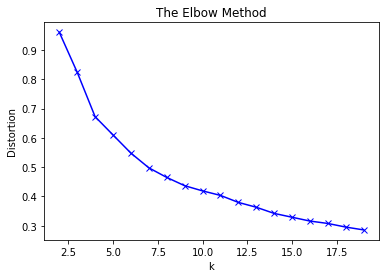

In [0]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

#### Silhouette Method
Maximize separation of clusters.

The silhouette score is a measure of how close each point is relative to it's cluster vs it's neighboring clusters. The value can range from -1 (closer to the neighbor, bad!) to +1 (it is the centroid). Mathematically, for a point xi:

S(i) = (B(i) - A(i) / max(A(i),B(i))

where:

A(i) is the average dissimilarity of the ith point to the other points in it's cluster

B(i) is the average dissimilarity of the ith point to all the points in the nearest cluster



https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [0]:
K = range(2,20)
X = data_scaled
silhouettes = []

for k in K: 
  cluster = KMeans(n_clusters = k) 
  cluster_labels = cluster.fit_predict(X) 

  # The silhouette_score gives the average value for all the samples. 
  silhouettes.append(silhouette_score(X, cluster_labels))

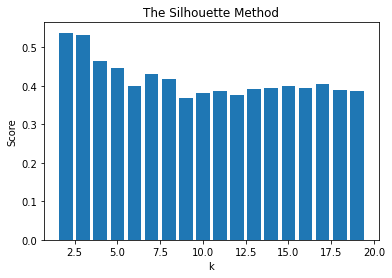

In [0]:
# Plot the silhouette scores
plt.bar(K, silhouettes)
plt.xlabel('k')
plt.ylabel('Score')
plt.title('The Silhouette Method')
plt.show()

In [0]:
c7,l7 = kmeans(7,data_scaled)
fig = px.scatter_3d(data_scaled, x='longitude', y='latitude', z='median_house_value',color=l7)
fig.show()

convergence in 11 iterations: centroids stopped moving


### Other considerations

- scale of features
- Convergence: Is k-means guaranteed to converge? Yes, sort of. In theory, it is possible to oscillate between solutions with identical distortion functions. Read the CS229 notes for details.
- Local optima: k-means is susceptible to local optima. To combat this, can run multiple times with different random initializations and pick the one with the lowest value of the distortion function.


### Resources

- http://cs229.stanford.edu/notes/cs229-notes7a.pdf
- https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/